In [21]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization, LayerNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [2]:
data_dir=os.path.join('dataset')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [3]:
paths_train_all

['dataset\\training-a\\a00000.png',
 'dataset\\training-a\\a00001.png',
 'dataset\\training-a\\a00002.png',
 'dataset\\training-a\\a00003.png',
 'dataset\\training-a\\a00004.png',
 'dataset\\training-a\\a00005.png',
 'dataset\\training-a\\a00006.png',
 'dataset\\training-a\\a00007.png',
 'dataset\\training-a\\a00008.png',
 'dataset\\training-a\\a00009.png',
 'dataset\\training-a\\a00010.png',
 'dataset\\training-a\\a00011.png',
 'dataset\\training-a\\a00012.png',
 'dataset\\training-a\\a00013.png',
 'dataset\\training-a\\a00014.png',
 'dataset\\training-a\\a00015.png',
 'dataset\\training-a\\a00016.png',
 'dataset\\training-a\\a00017.png',
 'dataset\\training-a\\a00018.png',
 'dataset\\training-a\\a00019.png',
 'dataset\\training-a\\a00020.png',
 'dataset\\training-a\\a00021.png',
 'dataset\\training-a\\a00022.png',
 'dataset\\training-a\\a00023.png',
 'dataset\\training-a\\a00024.png',
 'dataset\\training-a\\a00025.png',
 'dataset\\training-a\\a00026.png',
 'dataset\\training-a\\a0002

In [4]:
path_label_train_a

'dataset\\training-a.csv'

In [5]:
#Declaring constants
FIG_WIDTH=20 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
ROW_HEIGHT=3 
RESIZE_DIM=28 # The images will be resized to 28x28 pixels

In [6]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):

    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
#         X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):

    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [7]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [8]:
X_train_b.shape
# y_train_a, X_train_b,y_train_b, X_train_c,y_train_c, X_train_d,y_train_d, X_train_e,y_train_e

(359, 28, 28)

In [9]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 28, 28), (72045, 10))

In [10]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [11]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))

In [12]:
X_show_all=X_train_all

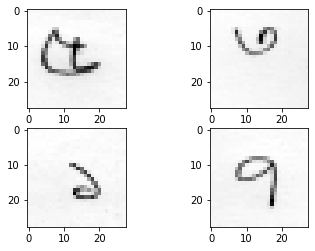

In [13]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [14]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],28, 28,1).astype('float32')
X_test_all = X_test_all.reshape(X_test_all.shape[0],28, 28,1).astype('float32')

In [15]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

In [16]:
indices=list(range(len(X_train_all)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80)
# train data
X_train=X_train_all[indices[:ind]] 
y_train=y_train_all[indices[:ind]]
# validation data
X_val=X_train_all[indices[-(len(indices)-ind):]] 
y_val=y_train_all[indices[-(len(indices)-ind):]]

In [17]:
from sklearn.model_selection import train_test_split
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_all, y_train_all, test_size=0.20, random_state=42, shuffle=True)

In [18]:
X_train.shape

(57636, 28, 28, 1)

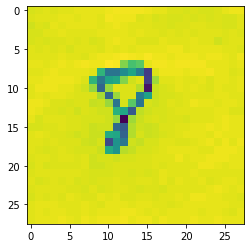

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
index = 500
plt.imshow(X_train[index])
plt.show()
y_train[index]

In [22]:
# Building model
model = keras.Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(LayerNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(LayerNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(LayerNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# compile model
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 layer_normalization (LayerN  (None, 26, 26, 64)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 32)        18464     
                                                                 
 layer_normalization_1 (Laye  (None, 11, 11, 32)       64        
 rNormalization)                                                 
                                                      

In [62]:
history = model.fit(X_train, y_train, batch_size=128, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
451/451 [==============================] - 161s 357ms/step - loss: 0.0880 - accuracy: 0.9696 - val_loss: 0.2257 - val_accuracy: 0.9410
Epoch 2/20
451/451 [==============================] - 161s 356ms/step - loss: 0.0851 - accuracy: 0.9704 - val_loss: 0.2195 - val_accuracy: 0.9414
Epoch 3/20
451/451 [==============================] - 154s 342ms/step - loss: 0.0852 - accuracy: 0.9705 - val_loss: 0.2353 - val_accuracy: 0.9369
Epoch 4/20
451/451 [==============================] - 155s 343ms/step - loss: 0.0806 - accuracy: 0.9722 - val_loss: 0.2467 - val_accuracy: 0.9348
Epoch 5/20
451/451 [==============================] - 153s 340ms/step - loss: 0.0814 - accuracy: 0.9713 - val_loss: 0.2379 - val_accuracy: 0.9394
Epoch 6/20
451/451 [==============================] - 153s 340ms/step - loss: 0.0786 - accuracy: 0.9730 - val_loss: 0.2142 - val_accuracy: 0.9459
Epoch 7/20
451/451 [==============================] - 154s 341ms/step - loss: 0.0753 - accuracy: 0.9749 - val_loss: 0.2286 -

In [63]:
model.save("cnn_3l_ln_25.h5")

In [22]:
model = keras.models.load_model("cnn_25.h5")

In [64]:
predictions_prob=model.predict(X_test_all) # get predictions for all the test data

551/551 [==============================] - 14s 25ms/step


In [65]:
n_sample=200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_all), size=n_sample)

C:\Users\tahmi\AppData\Local\Temp/ipykernel_5532/2674124788.py:38: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(j,n_per_row,i+1)


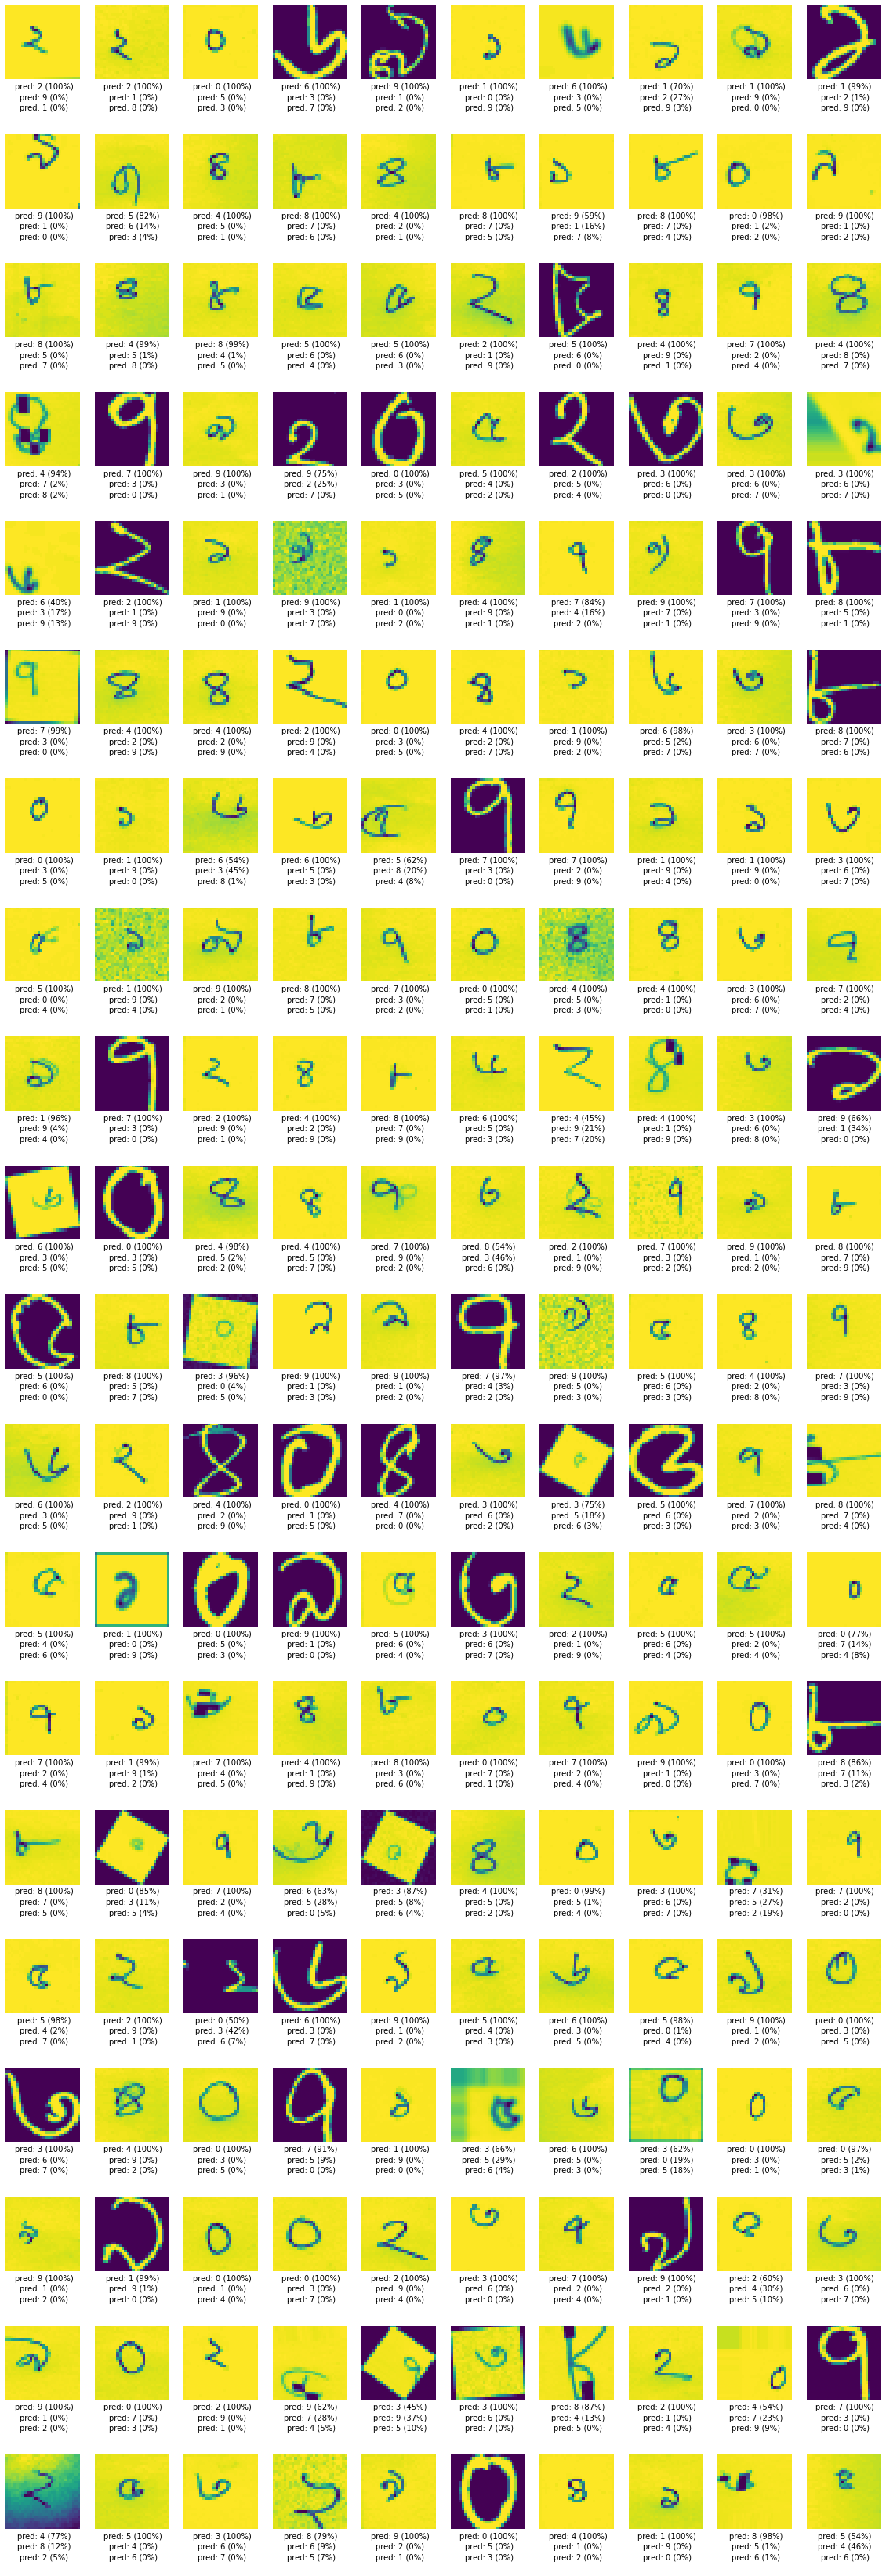

In [66]:
imshow_group(X=X_test_all[ind],y=None,y_pred=predictions_prob[ind])

In [67]:
np.argmax(predictions_prob[0])

4

In [68]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [69]:
keys=[get_key(path) for path in paths_test_all ]

In [70]:
create_submission(predictions=labels,keys=keys,path='submission_cnn_3l_ln_25.csv')

Test Data Accuracy Score : 0.80947